# Spooky Classification for 3 Authors
By : Hesham Asem

_____

here we have 3 kinds of phrases , for 3 fammous authors (Edgar Allan Poe  , HP Lovecraft , Mary Wollstonecraft Shelley) , & we need to build a model which is able to know the author depend on the phrase 

let's first import needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from wordcloud import WordCloud
import collections
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile , chi2
from sklearn.naive_bayes import MultinomialNB

then to read the training data

In [2]:
data = pd.read_csv('../input/spooky-author-identification/train/train.csv')  
print(f'Data Shape is {data.shape}')
data.head()

Data Shape is (19579, 3)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


now to define needed functions

In [3]:
def show_details() : 
    global data
    for col in data.columns : 
        print(f'for feature : {col}')
        print(f'Number of Nulls is   {data[col].isna().sum()}')
        print(f'Number of Unique values is   {len(data[col].unique())}')
        print(f'random Value {data[col][0]}')
        print(f'random Value {data[col][10]}')
        print(f'random Value {data[col][20]}')
        print('--------------------------')

def CountWords(text) :  
    
    all_words = []

    for i in range(text.shape[0]) : 
        this_phrase = list(text)[i]
        for word in this_phrase.split() : 
            all_words.append(word)

    print(f'Total words are {len(all_words)} words')   
    print('')
    print(f'Total unique words are {len(set(all_words))} words')   
    
def CommonWords(text ,show = True , kk=10) : 
    all_words = []

    for i in range(text.shape[0]) : 
        this_phrase = list(text)[i]
        for word in this_phrase.split() : 
            all_words.append(word)
    common_words = collections.Counter(all_words).most_common()
    k=0
    word_list =[]
    for word, i in common_words : 
        if not word.lower() in  nlp.Defaults.stop_words :
            if show : 
                print(f'The word is   {word}   repeated   {i}  times')
            word_list.append(word)
            k+=1
        if k==kk : 
            break
            
    return word_list

def SelectedData(feature , value , operation, selected_feature ):
    global data
    if operation==0 : 
        result = data[data[feature]==value][selected_feature]
    elif operation==1 : 
        result = data[data[feature] > value][selected_feature]
    elif operation==2 : 
        result = data[data[feature]< value][selected_feature]
    
    return result 

def LowerCase(feature , newfeature) : 
    global data
    def ApplyLower(text) : 
        return text.lower()
    data[newfeature] = data[feature].apply(ApplyLower)
    
def Drop(feature) :
    global data
    data.drop([feature],axis=1, inplace=True)
    data.head()
def Unique(feature) : 
    global data
    print(f'Number of unique vaure are {len(list(data[feature].unique()))} which are : \n {list(data[feature].unique())}')
    
def Encoder(feature , new_feature, drop = False) : 
    global data
    enc  = LabelEncoder()
    enc.fit(data[feature])
    data[new_feature] = enc.transform(data[feature])
    if drop == True : 
        data.drop([feature],axis=1, inplace=True)
        
def MakeCloud(text , title = 'Word Clouds' , w = 15 , h = 15):
    plt.figure(figsize=(w,h))
    plt.imshow(WordCloud(background_color="white",stopwords=set(stopwords.words('english')))
               .generate(" ".join([i for i in text.str.lower()])))
    plt.axis("off")
    plt.title(title)
    plt.show()
def BPlot(feature_1,feature_2) :
    global data
    sns.barplot(x=feature_1, y=feature_2 , data=data)
    
def CPlot(feature) : 
    global data
    sns.countplot(x=feature, data=data,facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))


____

# Text Processing

so let's start make basic processes in our Text here 

first to drop the feature id

In [4]:
Drop('id')

then to lowercase all texts , & to drop original text feature

In [5]:
LowerCase('text' , 'lower text')
Drop('text')

now how data looks like

In [6]:
data.head(20)

,author,lower text
0,EAP,"this process, however, afforded me no means of..."
1,HPL,it never once occurred to me that the fumbling...
2,EAP,"in his left hand was a gold snuff box, from wh..."
3,MWS,how lovely is spring as we looked from windsor...
4,HPL,"finding nothing else, not even gold, the super..."
5,MWS,"a youth passed in solitude, my best years spen..."
6,EAP,"the astronomer, perhaps, at this point, took r..."
7,EAP,the surcingle hung in ribands from my body.
8,EAP,i knew that you could not say to yourself 'ste...
9,MWS,i confess that neither the structure of langua...


let's be sure no Nulls exists

In [7]:
show_details()

for feature : author
Number of Nulls is   0
Number of Unique values is   3
random Value EAP
random Value MWS
random Value EAP
--------------------------
for feature : lower text
Number of Nulls is   0
Number of Unique values is   19578
random Value this process, however, afforded me no means of ascertaining the dimensions of my dungeon; as i might make its circuit, and return to the point whence i set out, without being aware of the fact; so perfectly uniform seemed the wall.
random Value he shall find that i can feel my injuries; he shall learn to dread my revenge" a few days after he arrived.
random Value now the net work was not permanently fastened to the hoop, but attached by a series of running loops or nooses.
--------------------------


who are authors we have here ? 

In [8]:
Unique('author')

Number of unique vaure are 3 which are : 
 ['EAP', 'HPL', 'MWS']


so we need to labelencode our authors here , so EAP will be 0 , HPL will be 1 & MWS will be 2 , we need to memorize these numbers to use in predicting test data

In [9]:
Encoder('author' , 'author code')
data.head()

,author,lower text,author code
0,EAP,"this process, however, afforded me no means of...",0
1,HPL,it never once occurred to me that the fumbling...,1
2,EAP,"in his left hand was a gold snuff box, from wh...",0
3,MWS,how lovely is spring as we looked from windsor...,2
4,HPL,"finding nothing else, not even gold, the super...",1


now how many words we have in all phrases  ? 

In [10]:
CountWords(data['lower text'])

Total words are 523356 words

Total unique words are 44895 words


about half million word , which depend on about 45K unique words

____


and we need to be sure that we have balances about of phrases for each category in the output



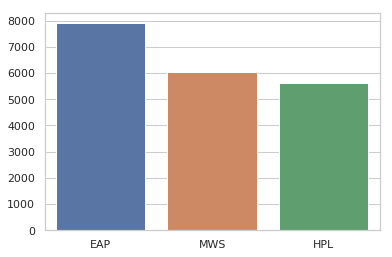

In [11]:
BPlot(data['author'].value_counts().index , data['author'].value_counts().values )

great , balanced amount

_____

# Common Words


let's have a look to most common used words ( stopwords will be excluded automatically from this function)

In [12]:
AllCommon = CommonWords(data['lower text'])

The word is   like   repeated   590  times
The word is   old   repeated   585  times
The word is   time   repeated   512  times
The word is   man   repeated   508  times
The word is   found   repeated   498  times
The word is   little   repeated   489  times
The word is   great   repeated   482  times
The word is   said   repeated   473  times
The word is   saw   repeated   472  times
The word is   me,   repeated   470  times


& it will be better to make wordcloud for all words

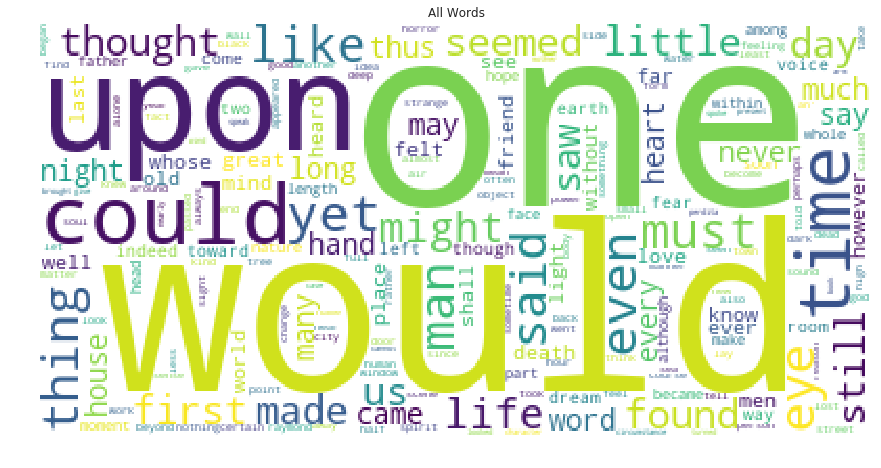

In [13]:
MakeCloud(data['lower text'] , 'All Words')

how about common words in phrases written by EAP ? 

In [14]:
ECommon = CommonWords(SelectedData('author','EAP',0,'lower text'))

The word is   said   repeated   267  times
The word is   and,   repeated   262  times
The word is   little   repeated   256  times
The word is   however,   repeated   227  times
The word is   great   repeated   211  times
The word is   found   repeated   194  times
The word is   long   repeated   183  times
The word is   having   repeated   178  times
The word is   like   repeated   167  times
The word is   mr.   repeated   164  times


also we can make it in cloud form 

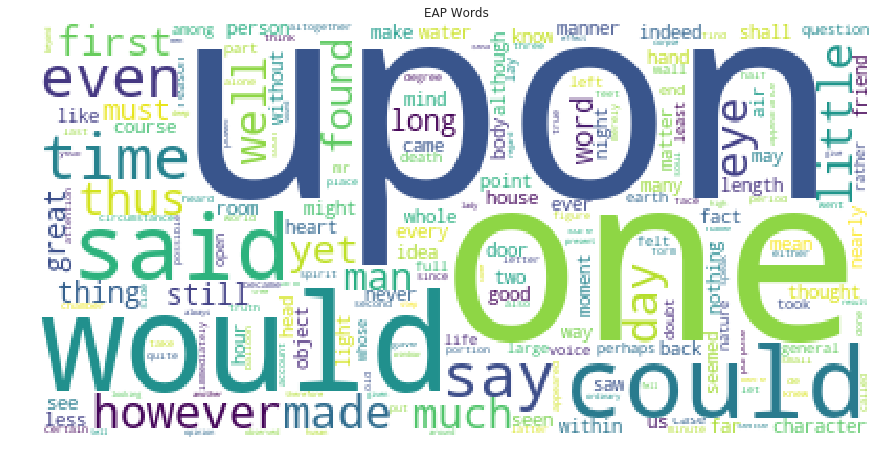

In [15]:
MakeCloud(SelectedData('author','EAP',0,'lower text') , 'EAP Words')

then repeat same process for HPL

In [16]:
HCommon = CommonWords(SelectedData('author','HPL',0,'lower text'))

The word is   old   repeated   378  times
The word is   .   repeated   281  times
The word is   like   repeated   262  times
The word is   saw   repeated   226  times
The word is   man   repeated   209  times
The word is   an'   repeated   194  times
The word is   things   repeated   192  times
The word is   came   repeated   191  times
The word is   great   repeated   186  times
The word is   time   repeated   182  times


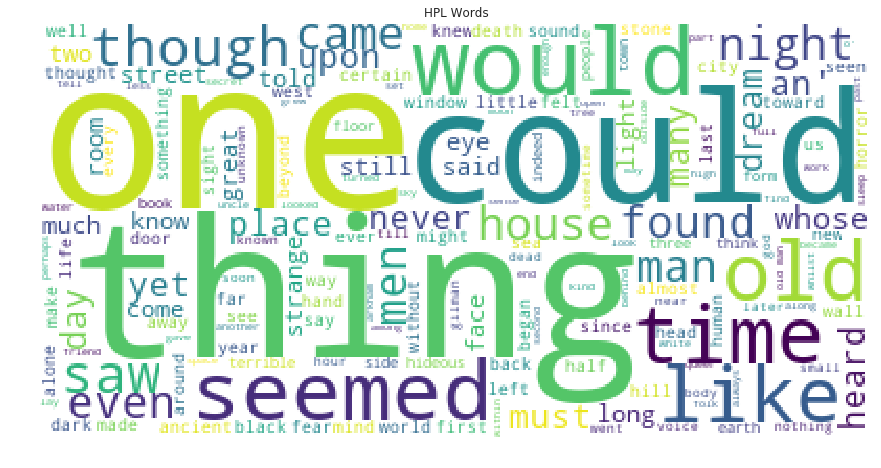

In [17]:
MakeCloud(SelectedData('author','HPL',0,'lower text') , 'HPL Words')

and for MWS

In [18]:
MCommon = CommonWords(SelectedData('author','MWS',0,'lower text'))

The word is   me,   repeated   248  times
The word is   life   repeated   186  times
The word is   me.   repeated   178  times
The word is   shall   repeated   178  times
The word is   love   repeated   178  times
The word is   eyes   repeated   172  times
The word is   heart   repeated   170  times
The word is   time   repeated   166  times
The word is   like   repeated   161  times
The word is   raymond   repeated   160  times


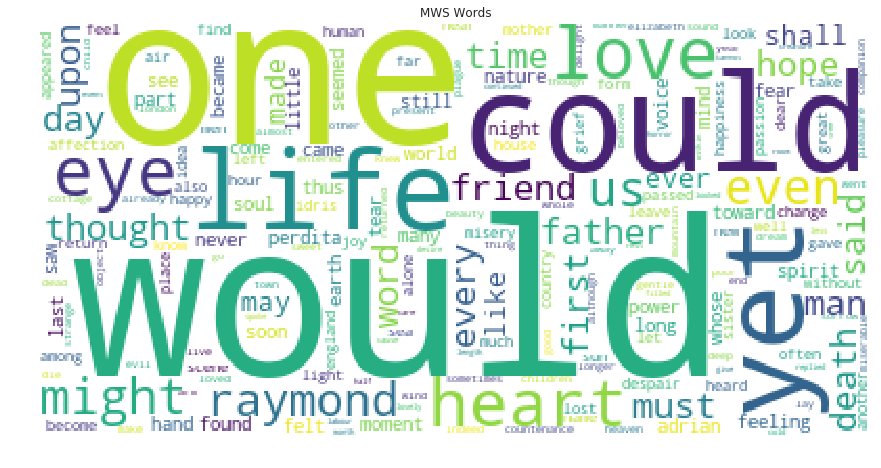

In [19]:
MakeCloud(SelectedData('author','MWS',0,'lower text') , 'MWS Words')

____

# More Data

we might need to know more features about these phrases , which might be helpful in our training

let's make a new feature about number of words in each phrase , & check if it will be a helpful feature

In [20]:
data['number of words'] = data['lower text'].apply(lambda x : len(x.split()))
print('mean words for EAP is  ' , SelectedData('author', 'EAP' , 0 , 'number of words').mean())  
print('mean words for HPL is  ' , SelectedData('author', 'HPL' , 0 , 'number of words').mean())  
print('mean words for MWS is  ' , SelectedData('author', 'MWS' , 0 , 'number of words').mean())  

mean words for EAP is   25.44240506329114
mean words for HPL is   27.799645075421473
mean words for MWS is   27.417273328921244


ok , the 3 means are very close to each other 

how about the number of charachters

In [21]:
data['number of chars'] = data['lower text'].apply(lambda x : len(x))
print('mean chars for EAP is  ' , SelectedData('author', 'EAP' , 0 , 'number of chars').mean())  
print('mean chars for HPL is  ' , SelectedData('author', 'HPL' , 0 , 'number of chars').mean())  
print('mean chars for MWS is  ' , SelectedData('author', 'MWS' , 0 , 'number of chars').mean())  

mean chars for EAP is   142.22594936708862
mean chars for HPL is   155.84347826086957
mean chars for MWS is   151.65982792852415


HPL prefer to write more letters , but still close to each other 

so how about number of punctuations ? 

In [22]:
data['number of punctuations'] = data['lower text'].apply(lambda x : len([k for k in  x if k in r'.,;:!?|\#$%^&*/']))
print('mean punctuations for EAP is  ' , SelectedData('author', 'EAP' , 0 , 'number of punctuations').mean())  
print('mean punctuations for HPL is  ' , SelectedData('author', 'HPL' , 0 , 'number of punctuations').mean())  
print('mean punctuations for MWS is  ' , SelectedData('author', 'MWS' , 0 , 'number of punctuations').mean())  

mean punctuations for EAP is   3.5493670886075948
mean punctuations for HPL is   2.8124223602484473
mean punctuations for MWS is   3.511912640635341


still not a big difference . so how about number of stop words ? 

In [23]:
data['number of stop'] = data['lower text'].apply(lambda x : len([k for k in  x if k in nlp.Defaults.stop_words ]))
print('mean stop for EAP is  ' , SelectedData('author', 'EAP' , 0 , 'number of stop').mean())  
print('mean stop for HPL is  ' , SelectedData('author', 'HPL' , 0 , 'number of stop').mean())  
print('mean stop for MWS is  ' , SelectedData('author', 'MWS' , 0 , 'number of stop').mean())  

mean stop for EAP is   17.162151898734177
mean stop for HPL is   18.75989352262644
mean stop for MWS is   17.738914626075445


almost equal each other . . 

so it might not be helpful to use any of those features

_____

# Training the Data

so let's start prepare our data to be ready for training 

In [24]:
data.head()

,author,lower text,author code,number of words,number of chars,number of punctuations,number of stop
0,EAP,"this process, however, afforded me no means of...",0,41,231,7,26
1,HPL,it never once occurred to me that the fumbling...,1,14,71,1,7
2,EAP,"in his left hand was a gold snuff box, from wh...",0,36,200,5,27
3,MWS,how lovely is spring as we looked from windsor...,2,34,206,4,24
4,HPL,"finding nothing else, not even gold, the super...",1,27,174,4,21


let's define X & y , since we'll not use any of those new features 

In [25]:
X = data['lower text']
y = data['author code']

then we'll have to vectorize the text & check its shape

In [26]:
VecModel = TfidfVectorizer()
XVec = VecModel.fit_transform(X)

print(f'The new shape for X is {XVec.shape}')

The new shape for X is (19579, 25068)


about 25K features . . 

how about reducing them using SelectPercentile from sklearn , to its half , using chi2 function

In [27]:
FeatureSelection = SelectPercentile(score_func = chi2, percentile=50)
X_data = FeatureSelection.fit_transform(XVec, y)

print('X Shape is ' , X_data.shape)

X Shape is  (19579, 12534)


ok looks fine , not to split it into training & testing data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.33, random_state=44, shuffle =True)

print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (13117, 12534)
X_test shape is  (6462, 12534)
y_train shape is  (13117,)
y_test shape is  (6462,)


now to use MultiNomial Naive Bayes model for classification , with alpha only 0.05 to get the best score

In [29]:
MultinomialNBModel = MultinomialNB(alpha=0.05)
MultinomialNBModel.fit(X_train, y_train)

print('MultinomialNBModel Train Score is : ' , MultinomialNBModel.score(X_train, y_train))
print('MultinomialNBModel Test Score is : ' , MultinomialNBModel.score(X_test, y_test))

MultinomialNBModel Train Score is :  0.9451094000152473
MultinomialNBModel Test Score is :  0.8714020427112349


well , 87% accuracy in test score is not the best but it's acceptable , may be we can increase it by more tuning for the parameters

_____

# Predicting Test Data

now let's moving to predicting test data

In [30]:
data = pd.read_csv('../input/spooky-author-identification/test/test.csv')  
print(f'Test data Shape is {data.shape}')
data.head()

Test data Shape is (8392, 2)


,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


we have to lower case it as well 

In [31]:
LowerCase('text' , 'lower text')
Drop('text')
data.head()

,id,lower text
0,id02310,"still, as i urged our leaving ireland with suc..."
1,id24541,"if a fire wanted fanning, it could readily be ..."
2,id00134,and when they had broken down the frail door t...
3,id27757,while i was thinking how i should possibly man...
4,id04081,i am not sure to what limit his knowledge may ...


then define X

In [32]:
X = data['lower text']

now to apply Vectorizing Model to it , & it have bring the same 25K features

In [33]:
XVec = VecModel.transform(X)
print(f'The new shape for X is {XVec.shape}')

The new shape for X is (8392, 25068)


perfect  . again we have to apply SelectPercentile Model to it , to select same half features

In [34]:
X_data = FeatureSelection.transform(XVec)
print('X Shape is ' , X_data.shape)

X Shape is  (8392, 12534)


now it's ready for predicting

In [35]:
y_pred = MultinomialNBModel.predict(X_data)
y_pred_prob = MultinomialNBModel.predict_proba(X_data)
print('Predicted Value for MultinomialNBModel is : ' , y_pred[:10])
print('Prediction Probabilities Value for MultinomialNBModel is : ' , y_pred_prob[:10])

Predicted Value for MultinomialNBModel is :  [2 0 1 0 0 0 0 2 0 0]
Prediction Probabilities Value for MultinomialNBModel is :  [[0.148309   0.03970744 0.81198356]
 [0.87593637 0.07567866 0.04838497]
 [0.39508693 0.55877011 0.04614296]
 [0.49365561 0.47651875 0.02982564]
 [0.84865463 0.1108134  0.04053197]
 [0.57855229 0.37897165 0.04247607]
 [0.74963944 0.14695705 0.10340352]
 [0.14220143 0.12665468 0.73114389]
 [0.96727115 0.02781345 0.00491541]
 [0.67435271 0.08977916 0.23586813]]


great , now to open the submission file , to insert the answer

In [36]:
data = pd.read_csv('../input/spooky-author-identification/sample_submission/sample_submission.csv')  
print(f'Test data Shape is {data.shape}')
data.head()

Test data Shape is (8392, 4)


,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


here they don't need the argmax prediction , but the probabilities , so we'll use predict probability method from same model , then transform it into dataframe , & concatenate to the original id feature

In [37]:
idd = data['id']
FinalResults = pd.DataFrame(y_pred_prob  ,columns= ['EAP','HPL','MWS'])
FinalResults.insert(0,'id',idd)

how it looks now ? 

In [38]:
FinalResults.head()

,id,EAP,HPL,MWS
0,id02310,0.148309,0.039707,0.811984
1,id24541,0.875936,0.075679,0.048385
2,id00134,0.395087,0.558770,0.046143
3,id27757,0.493656,0.476519,0.029826
4,id04081,0.848655,0.110813,0.040532


great, now submission 

In [39]:
FinalResults.to_csv("sample_submission.csv",index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

hope you enjoyed it !
